# ResNet-18 Custom Image Predictor

This notebook loads a pre-trained ResNet-18 model and predicts custom images for alphanumeric character classification. The model was trained on 64x64 grayscale images representing characters 'a'-'z', 'A'-'Z', and digits '0'-'9', with folder names corresponding to ASCII values.

## 🎯 Features:
- **Single Image Prediction**: Predict any custom image with confidence scores
- **Batch Prediction**: Process multiple images from directories
- **Interactive Visualization**: View predictions with original and processed images
- **Top-K Predictions**: See the top 5 most likely characters
- **Error Handling**: Robust error checking and troubleshooting
- **Performance Analysis**: Analyze prediction confidence and performance

## 📋 Requirements:
- Trained ResNet-18 model file (`resnet18_model.pth`)
- Custom images (any format: PNG, JPG, JPEG, etc.)
- Python libraries: torch, torchvision, PIL, matplotlib, numpy

## 🚀 Quick Start:
1. Update the `MODEL_PATH` and `CUSTOM_IMAGE_PATH` variables
2. Run all cells to load the model
3. Use the prediction functions for your custom images

## 1. Setup Environment and Import Libraries

In [64]:
# Import all necessary libraries for image prediction
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Image processing libraries
from PIL import Image
import numpy as np
import cv2

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# System and file handling
import os
import glob
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Progress tracking
from tqdm import tqdm

print("=" * 80)
print(" RESNET-18 CUSTOM IMAGE PREDICTOR")
print("=" * 80)
print(f" PyTorch Version: {torch.__version__}")
print(f" CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f" GPU Device: {torch.cuda.get_device_name(0)}")
    print(f" GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("  Using CPU for inference")

print(f" PIL Version: {Image.__version__}")
print(f" NumPy Version: {np.__version__}")
print("=" * 80)

 RESNET-18 CUSTOM IMAGE PREDICTOR
 PyTorch Version: 2.5.1
 CUDA Available: True
 GPU Device: NVIDIA GeForce RTX 3060 Ti
 GPU Memory: 7.65 GB
 PIL Version: 11.1.0
 NumPy Version: 1.26.4


## 2. Configuration and Model Loading

**🔧 Configuration**: Update these paths according to your setup

In [65]:
# ============================================================================
#  CONFIGURATION - UPDATE THESE PATHS FOR YOUR SETUP
# ============================================================================

# Model and dataset paths
BASE_PATH = "/home/ubuntu/Desktop/AIML project/AlphaNum"
TRAIN_PATH = os.path.join(BASE_PATH, "train")  # Needed to get class information
RESULTS_PATH = "/home/ubuntu/Desktop/AIML project/results/ResNet-18"
MODEL_PATH = os.path.join(RESULTS_PATH, "resnet18_model.pth")

#  CHANGE THIS TO YOUR CUSTOM IMAGE PATH 
CUSTOM_IMAGE_PATH = "/home/ubuntu/Pictures/asaad.png"


# Output directory for results
OUTPUT_DIR = "/home/ubuntu/Desktop/AIML project/results/ResNet-18/prediction_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(" Configuration:")
print(f"   Model Path: {MODEL_PATH}")
#print(f"   Train Path: {TRAIN_PATH}")
print(f"   Custom Image: {CUSTOM_IMAGE_PATH}")
print(f"   Output Directory: {OUTPUT_DIR}")
print(f"   Device: {device}")
print()

# Verify paths exist
if not os.path.exists(MODEL_PATH):
    print(f" Model file not found: {MODEL_PATH}")
    print("   Please train the ResNet-18 model first!")
else:
    print(f" Model file found: {MODEL_PATH}")

if not os.path.exists(TRAIN_PATH):
    print(f" Training data not found: {TRAIN_PATH}")
    print("   Needed to get class information!")
else:
   print(f" Training data found: {TRAIN_PATH}")

if os.path.exists(CUSTOM_IMAGE_PATH):
    print(f" Custom image found: {CUSTOM_IMAGE_PATH}")
else:
    print(f"  Custom image not found: {CUSTOM_IMAGE_PATH}")
    print("   You can update CUSTOM_IMAGE_PATH variable above")

 Configuration:
   Model Path: /home/ubuntu/Desktop/AIML project/results/ResNet-18/resnet18_model.pth
   Custom Image: /home/ubuntu/Pictures/asaad.png
   Output Directory: /home/ubuntu/Desktop/AIML project/results/ResNet-18/prediction_results
   Device: cuda:0

 Model file found: /home/ubuntu/Desktop/AIML project/results/ResNet-18/resnet18_model.pth
 Training data found: /home/ubuntu/Desktop/AIML project/AlphaNum/train
 Custom image found: /home/ubuntu/Pictures/asaad.png


In [66]:
# ============================================================================
# LOAD SAVED RESNET-18 MODEL
# ============================================================================

def load_resnet18_model(model_path, train_path, device):
    """
    Load the trained ResNet-18 model from saved state dictionary.
    
    Args:
        model_path: Path to the saved model (.pth file)
        train_path: Path to training data (to get class info)
        device: Device to load model on
        
    Returns:
        model: Loaded model ready for inference
        class_names: List of class names (ASCII codes)
        num_classes: Number of classes
    """
    print("\n" + "=" * 60)
    print(" LOADING RESNET-18 MODEL")
    print("=" * 60)
    
    try:
        # Step 1: Get class information from training dataset
        print(" Loading class information from training dataset...")
        temp_dataset = datasets.ImageFolder(root=train_path)
        class_names = sorted(temp_dataset.classes)
        num_classes = len(class_names)
        
        print(f"   Classes found: {num_classes}")
        print(f"   Sample classes: {class_names[:10]}...")
        
        # Step 2: Recreate model architecture (must match training)
        print("  Recreating ResNet-18 architecture...")
        model = resnet18(weights=None)
        
        # Apply same modifications as during training (64x64 configuration)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Keep maxpool for 64x64 images (no change needed)
        
        # IMPORTANT: Must use Sequential with Dropout to match training architecture!
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),  # Must match the training configuration
            nn.Linear(num_ftrs, num_classes)
        )
        
        # Step 3: Load saved weights
        print(" Loading saved model weights...")
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
        
        # Step 4: Set to evaluation mode and move to device
        model.eval()
        model.to(device)
        
        print("Model loaded successfully!")
        print(f"   Architecture: ResNet-18 (modified for 64x64 grayscale)")
        print(f"   Input channels: {model.conv1.in_channels}")
        print(f"   Output classes: {num_classes}")
        print(f"   Dropout: 0.5")
        print(f"   Device: {device}")
        
        return model, class_names, num_classes
        
    except Exception as e:
        print(f" Error loading model: {str(e)}")
        return None, None, None

# Load the model
if os.path.exists(MODEL_PATH) and os.path.exists(TRAIN_PATH):
    loaded_model, class_names, num_classes = load_resnet18_model(MODEL_PATH, TRAIN_PATH, device)
    
    if loaded_model is not None:
        print("\n Model ready for predictions!")
        
        # Display class mapping examples
        print(f"\n Class Mapping Examples:")
        for i, class_name in enumerate(class_names[:10]):
            if class_name != '999':
                char = chr(int(class_name))
                print(f"   ASCII {class_name} → '{char}'")
            else:
                print(f"   ASCII {class_name} → 'NULL' (noise/unknown)")
        if len(class_names) > 10:
            print(f"   ... and {len(class_names) - 10} more classes")
    else:
        print(" Failed to load model. Please check the model file and paths.")
else:
    print(" Cannot load model - missing required files.")
    loaded_model, class_names, num_classes = None, None, None



 LOADING RESNET-18 MODEL
 Loading class information from training dataset...
   Classes found: 53
   Sample classes: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109']...
  Recreating ResNet-18 architecture...
 Loading saved model weights...
Model loaded successfully!
   Architecture: ResNet-18 (modified for 64x64 grayscale)
   Input channels: 1
   Output classes: 53
   Dropout: 0.5
   Device: cuda:0

 Model ready for predictions!

 Class Mapping Examples:
   ASCII 100 → 'd'
   ASCII 101 → 'e'
   ASCII 102 → 'f'
   ASCII 103 → 'g'
   ASCII 104 → 'h'
   ASCII 105 → 'i'
   ASCII 106 → 'j'
   ASCII 107 → 'k'
   ASCII 108 → 'l'
   ASCII 109 → 'm'
   ... and 43 more classes


## 3. Image Preprocessing Functions

Define the preprocessing pipeline that matches the training configuration.

In [67]:
# ============================================================================
# IMAGE PREPROCESSING FUNCTIONS
# ============================================================================

# Define the same transforms used during training
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((64, 64)),                  # Resize to 64x64
    transforms.ToTensor(),                        # Convert to tensor [0,1]
    transforms.Normalize((0.5,), (0.5,))         # Normalize to [-1,1]
])

def preprocess_image(image_path, transform=None, show_steps=False):
    """
    Preprocess a single image for model prediction.
    
    Args:
        image_path: Path to the image file
        transform: Transform pipeline (default: data_transforms)
        show_steps: Whether to visualize preprocessing steps
        
    Returns:
        image_tensor: Preprocessed image tensor ready for model
        original_image: Original PIL image
        processed_image: Processed PIL image (64x64 grayscale)
    """
    if transform is None:
        transform = data_transforms
    
    try:
        # Load original image
        original_image = Image.open(image_path)
        original_size = original_image.size
        
        # Convert to RGB if needed (for consistent processing)
        if original_image.mode not in ['RGB', 'L']:
            original_image = original_image.convert('RGB')
        
        # Apply transformations
        image_tensor = transform(original_image).unsqueeze(0)
        
        # Create processed image for visualization
        processed_image = original_image.convert('L').resize((64, 64))
        
        if show_steps:
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            
            # Original
            axes[0].imshow(original_image, cmap='gray' if original_image.mode == 'L' else None)
            axes[0].set_title(f'Original\n{original_size}', fontweight='bold')
            axes[0].axis('off')
            
            # Grayscale
            gray_img = original_image.convert('L')
            axes[1].imshow(gray_img, cmap='gray')
            axes[1].set_title(f'Grayscale\n{gray_img.size}', fontweight='bold')
            axes[1].axis('off')
            
            # Resized
            axes[2].imshow(processed_image, cmap='gray')
            axes[2].set_title('Processed\n(64x64)', fontweight='bold')
            axes[2].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"📸 Image preprocessing complete:")
            print(f"   Original size: {original_size}")
            print(f"   Final size: (64, 64)")
            print(f"   Tensor shape: {image_tensor.shape}")
        
        return image_tensor, original_image, processed_image
        
    except Exception as e:
        print(f" Error preprocessing image {image_path}: {str(e)}")
        return None, None, None

def batch_preprocess_images(image_paths, transform=None, max_display=5):
    """
    Preprocess multiple images for batch prediction.
    
    Args:
        image_paths: List of image file paths
        transform: Transform pipeline
        max_display: Maximum number of images to display
        
    Returns:
        image_tensors: List of preprocessed tensors
        original_images: List of original PIL images
        valid_paths: List of successfully processed paths
    """
    if transform is None:
        transform = data_transforms
    
    image_tensors = []
    original_images = []
    valid_paths = []
    
    print(f" Processing {len(image_paths)} images...")
    
    for i, img_path in enumerate(tqdm(image_paths)):
        tensor, original, processed = preprocess_image(img_path, transform, show_steps=False)
        
        if tensor is not None:
            image_tensors.append(tensor)
            original_images.append(original)
            valid_paths.append(img_path)
        else:
            print(f"  Skipped invalid image: {img_path}")
    
    print(f" Successfully processed {len(image_tensors)}/{len(image_paths)} images")
    
    # Display sample processed images
    if len(original_images) > 0 and max_display > 0:
        display_count = min(max_display, len(original_images))
        
        fig, axes = plt.subplots(2, display_count, figsize=(3*display_count, 6))
        if display_count == 1:
            axes = axes.reshape(2, 1)
            
        for i in range(display_count):
            # Original
            axes[0, i].imshow(original_images[i], cmap='gray' if original_images[i].mode == 'L' else None)
            axes[0, i].set_title(f'Original {i+1}', fontweight='bold')
            axes[0, i].axis('off')
            
            # Processed
            processed_img = original_images[i].convert('L').resize((64, 64))
            axes[1, i].imshow(processed_img, cmap='gray')
            axes[1, i].set_title(f'Processed {i+1}', fontweight='bold')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return image_tensors, original_images, valid_paths

print(" Preprocessing functions defined successfully!")
print(f" Transform pipeline: Grayscale → Resize(64,64) → ToTensor → Normalize")


 Preprocessing functions defined successfully!
 Transform pipeline: Grayscale → Resize(64,64) → ToTensor → Normalize


## 4. Single Image Prediction Functions

Functions for predicting individual custom images with detailed analysis.

In [68]:
# ============================================================================
# SINGLE IMAGE PREDICTION FUNCTIONS
# ============================================================================

def ascii_to_character(ascii_code):
    """Convert ASCII code to readable character."""
    try:
        if ascii_code == '999':
            return 'NULL'
        return chr(int(ascii_code))
    except (ValueError, OverflowError):
        return 'UNKNOWN'

def predict_single_image(model, image_path, class_names, device, top_k=5, show_visualization=True):
    """
    Predict a single custom image with detailed analysis.
    
    Args:
        model: Trained ResNet-18 model
        image_path: Path to the image file
        class_names: List of class names (ASCII codes)
        device: Device for inference
        top_k: Number of top predictions to return
        show_visualization: Whether to display visualization
        
    Returns:
        results: Dictionary with prediction results
    """
    print("\n" + "=" * 70)
    print(f" PREDICTING IMAGE: {os.path.basename(image_path)}")
    print("=" * 70)
    
    # Preprocess image
    image_tensor, original_image, processed_image = preprocess_image(
        image_path, show_steps=show_visualization
    )
    
    if image_tensor is None:
        return None
    
    # Move to device
    image_tensor = image_tensor.to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)
    
    # Get top-k predictions
    top_k_probs, top_k_indices = torch.topk(probabilities[0], top_k)
    
    # Prepare results
    predicted_class = class_names[predicted_idx.item()]
    predicted_char = ascii_to_character(predicted_class)
    confidence_score = confidence.item() * 100
    
    # Create top-k results
    top_predictions = []
    for i, (prob, idx) in enumerate(zip(top_k_probs, top_k_indices)):
        class_name = class_names[idx.item()]
        char = ascii_to_character(class_name)
        prob_percent = prob.item() * 100
        top_predictions.append({
            'rank': i + 1,
            'character': char,
            'ascii_code': class_name,
            'confidence': prob_percent
        })
    
    # Print results
    print(f" PREDICTION RESULTS:")
    print(f"    File: {os.path.basename(image_path)}")
    print(f"    Predicted Character: '{predicted_char}'")
    print(f"    ASCII Code: {predicted_class}")
    print(f"    Confidence: {confidence_score:.2f}%")
    print(f"    Original Size: {original_image.size}")
    print(f"    Processed Size: (64, 64)")
    
    print(f"\n TOP {top_k} PREDICTIONS:")
    for pred in top_predictions:
        print(f"   {pred['rank']}. '{pred['character']}' (ASCII: {pred['ascii_code']}) - {pred['confidence']:.2f}%")
    
    # Visualization
    if show_visualization:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image
        axes[0].imshow(original_image, cmap='gray' if original_image.mode == 'L' else None)
        axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
        axes[0].axis('off')
        
        # Processed image
        axes[1].imshow(processed_image, cmap='gray')
        axes[1].set_title('Processed (64x64)', fontsize=14, fontweight='bold')
        axes[1].axis('off')
        
        # Prediction visualization
        axes[2].text(0.5, 0.7, f"Prediction: '{predicted_char}'", 
                    ha='center', va='center', fontsize=20, fontweight='bold',
                    transform=axes[2].transAxes, color='green')
        axes[2].text(0.5, 0.5, f"ASCII: {predicted_class}", 
                    ha='center', va='center', fontsize=16,
                    transform=axes[2].transAxes)
        axes[2].text(0.5, 0.3, f"Confidence: {confidence_score:.2f}%", 
                    ha='center', va='center', fontsize=16,
                    transform=axes[2].transAxes)
        axes[2].set_xlim(0, 1)
        axes[2].set_ylim(0, 1)
        axes[2].axis('off')
        axes[2].set_title('Result', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Top predictions bar chart
        if top_k > 1:
            fig, ax = plt.subplots(figsize=(10, 6))
            chars = [pred['character'] for pred in top_predictions]
            confidences = [pred['confidence'] for pred in top_predictions]
            colors = ['green' if i == 0 else 'orange' if i == 1 else 'gray' for i in range(len(chars))]
            
            bars = ax.bar(chars, confidences, color=colors, alpha=0.7)
            ax.set_title(f'Top {top_k} Predictions', fontsize=16, fontweight='bold')
            ax.set_xlabel('Character', fontsize=12)
            ax.set_ylabel('Confidence (%)', fontsize=12)
            ax.grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for bar, conf in zip(bars, confidences):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                       f'{conf:.1f}%', ha='center', va='bottom', fontweight='bold')
            
            plt.tight_layout()
            plt.show()
    
    # Compile results
    results = {
        'file_path': image_path,
        'file_name': os.path.basename(image_path),
        'predicted_character': predicted_char,
        'ascii_code': predicted_class,
        'confidence': confidence_score,
        'original_size': original_image.size,
        'top_predictions': top_predictions,
        'success': True
    }
    
    return results

def predict_and_save_results(model, image_path, class_names, device, output_dir=None, top_k=5):
    """
    Predict image and save results to file.
    
    Args:
        model: Trained model
        image_path: Path to image
        class_names: List of class names
        device: Device for inference
        output_dir: Directory to save results
        top_k: Number of top predictions
        
    Returns:
        results: Prediction results dictionary
    """
    # Make prediction
    results = predict_single_image(model, image_path, class_names, device, top_k, show_visualization=False)
    
    if results is None:
        return None
    
    # Save results if output directory is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        
        # Create results filename
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        results_file = os.path.join(output_dir, f"{base_name}_prediction.json")
        
        # Save to JSON
        with open(results_file, 'w') as f:
            json.dump(results, f, indent=2)
        
        print(f" Results saved to: {results_file}")
    
    return results

print(" Single image prediction functions defined successfully!")
print(" Functions: predict_single_image(), predict_and_save_results()")

 Single image prediction functions defined successfully!
 Functions: predict_single_image(), predict_and_save_results()


## 5. Quick Prediction - Custom Image

**🚀 Quick Start**: Change the `CUSTOM_IMAGE_PATH` above and run this cell!


 PREDICTING IMAGE: asaad.png


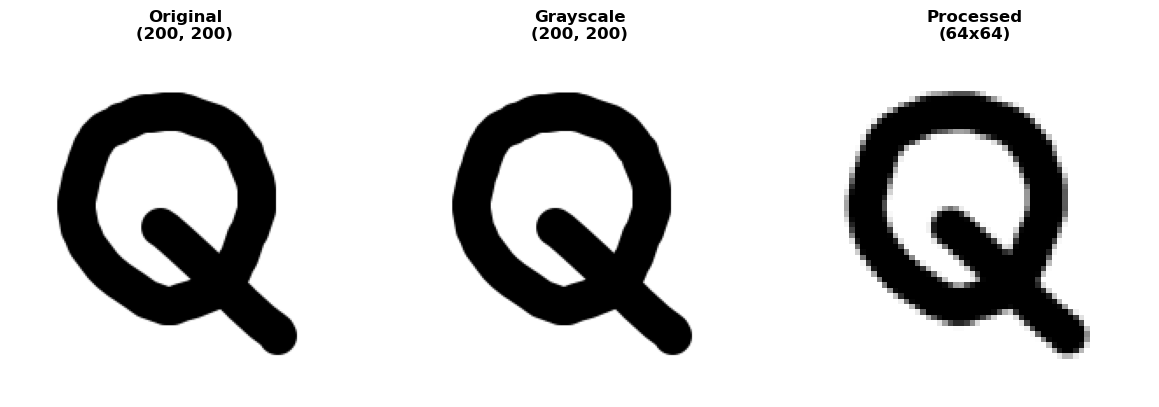

📸 Image preprocessing complete:
   Original size: (200, 200)
   Final size: (64, 64)
   Tensor shape: torch.Size([1, 1, 64, 64])
 PREDICTION RESULTS:
    File: asaad.png
    Predicted Character: 'Q'
    ASCII Code: 81
    Confidence: 93.48%
    Original Size: (200, 200)
    Processed Size: (64, 64)

 TOP 5 PREDICTIONS:
   1. 'Q' (ASCII: 81) - 93.48%
   2. 'G' (ASCII: 71) - 0.26%
   3. 'B' (ASCII: 66) - 0.16%
   4. 'I' (ASCII: 73) - 0.16%
   5. 'L' (ASCII: 76) - 0.16%


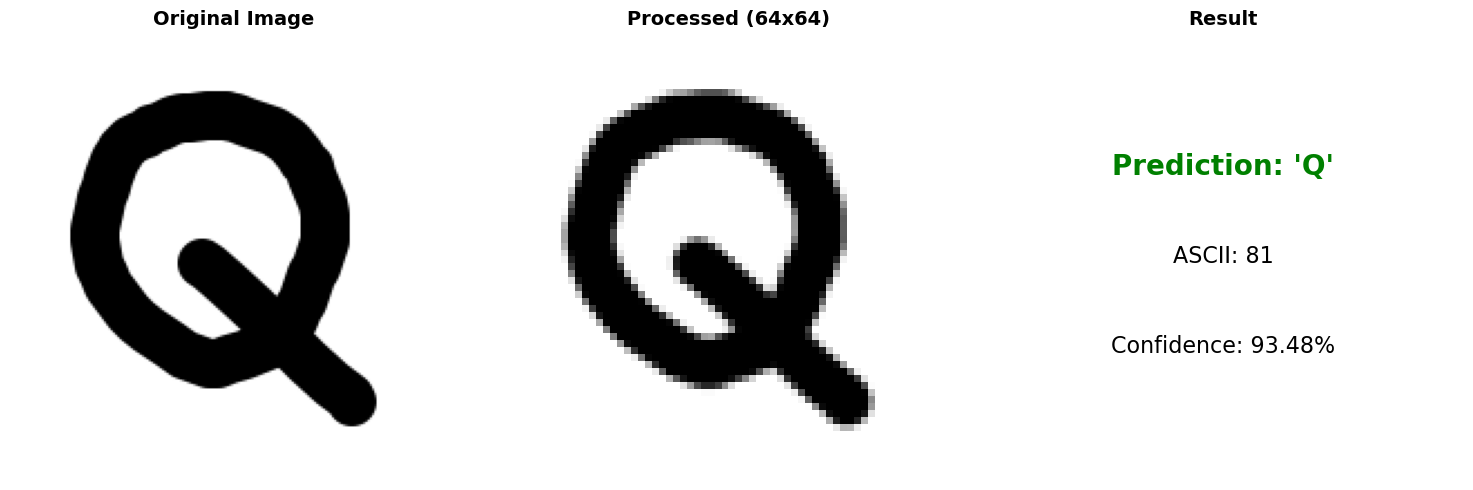

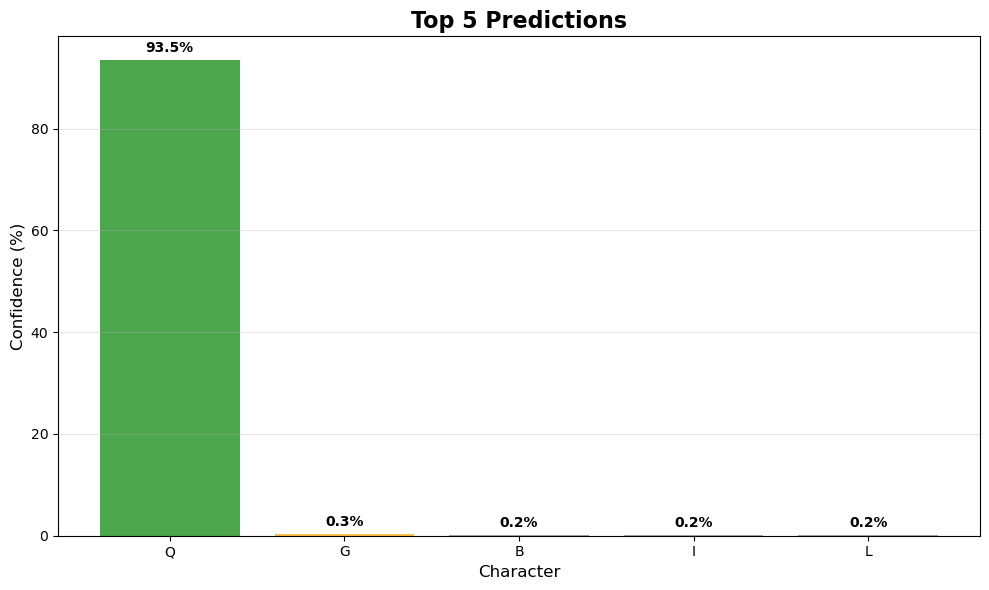


 PREDICTING IMAGE: asaad.png
 PREDICTION RESULTS:
    File: asaad.png
    Predicted Character: 'Q'
    ASCII Code: 81
    Confidence: 93.48%
    Original Size: (200, 200)
    Processed Size: (64, 64)

 TOP 5 PREDICTIONS:
   1. 'Q' (ASCII: 81) - 93.48%
   2. 'G' (ASCII: 71) - 0.26%
   3. 'B' (ASCII: 66) - 0.16%
   4. 'I' (ASCII: 73) - 0.16%
   5. 'L' (ASCII: 76) - 0.16%
 Results saved to: /home/ubuntu/Desktop/AIML project/results/ResNet-18/prediction_results/asaad_prediction.json

 Prediction completed successfully!
 Summary:
   Predicted: 'Q'
   Confidence: 93.48%
   Results saved to: /home/ubuntu/Desktop/AIML project/results/ResNet-18/prediction_results


In [69]:
# ============================================================================
#  QUICK PREDICTION - PREDICT YOUR CUSTOM IMAGE
# ============================================================================

# Check if model is loaded and image exists
if loaded_model is not None and class_names is not None:
    if os.path.exists(CUSTOM_IMAGE_PATH):
        # Predict the custom image
        results = predict_single_image(
            model=loaded_model,
            image_path=CUSTOM_IMAGE_PATH,
            class_names=class_names,
            device=device,
            top_k=5,
            show_visualization=True
        )
        
        if results:
            # Save results
            results_with_save = predict_and_save_results(
                model=loaded_model,
                image_path=CUSTOM_IMAGE_PATH,
                class_names=class_names,
                device=device,
                output_dir=OUTPUT_DIR,
                top_k=5
            )
            
            print("\n Prediction completed successfully!")
            print(f" Summary:")
            print(f"   Predicted: '{results['predicted_character']}'")
            print(f"   Confidence: {results['confidence']:.2f}%")
            print(f"   Results saved to: {OUTPUT_DIR}")
        else:
            print(" Failed to predict image.")
            
    else:
        print(f" Custom image not found: {CUSTOM_IMAGE_PATH}")
        
else:
    print(" Model not loaded. Please run the model loading cells first.")
    if loaded_model is None:
        print("   - Model loading failed")
    if class_names is None:
        print("   - Class names not loaded")